In [16]:

import pandas as pd
import numpy as np
import matplotlib
import statsmodels
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import itertools

warnings.filterwarnings('ignore')
import os


In [17]:
os.chdir(r"C:\Users\BIG SHARK TECHNOLOGY\Desktop\Inflation")
os.getcwd()

'C:\\Users\\BIG SHARK TECHNOLOGY\\Desktop\\Inflation'

In [18]:
df=pd.read_csv("data/raw_inflation_data.csv")
df

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.474764,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.098562,6.446877,6.221375,4.689806,4.102851,5.191629,6.824727,10.883478,7.399186,4.489789
2,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.661709,4.383892,4.975952,0.626149,2.302373,5.601888,5.133203,13.712102,-4.644709,-6.601186
3,Africa Western and Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.130817,1.487416,1.725486,1.784050,1.983092,2.490378,3.745568,7.949251,5.221168,3.608044
4,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.355972,30.694415,29.844480,19.628938,17.080954,22.271539,25.754295,21.355290,13.644102,28.240495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.536929,0.273169,1.488234,1.053798,2.675992,0.198228,3.353691,11.580510,4.944324,1.619450
262,"Yemen, Rep.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,South Africa,1.288877,2.102351,1.246275,1.337971,2.534989,4.069019,3.489237,3.538966,1.986134,...,4.518691,6.602908,5.186187,4.509873,4.102851,3.232388,4.618745,7.039873,6.075244,4.361152
264,Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.110593,17.869730,6.577312,7.494572,9.150316,15.733060,22.020768,10.993204,10.884532,14.985626


In [19]:
df = df.rename(columns={"Country Name": "country name"})

In [20]:
df = df.melt(
    id_vars=["country name"],   
    var_name="year",        
    value_name="inflation" 
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17290 entries, 0 to 17289
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country name  17290 non-null  object 
 1   year          17290 non-null  object 
 2   inflation     11230 non-null  float64
dtypes: float64(1), object(2)
memory usage: 405.4+ KB


In [21]:
df["year"] = pd.to_numeric(df["year"], errors= "coerce")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17290 entries, 0 to 17289
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country name  17290 non-null  object 
 1   year          17290 non-null  int64  
 2   inflation     11230 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 405.4+ KB


In [22]:
# List of countries to analyze
countries = ["Cameroon", "Ghana", "Nigeria", "Cote d'Ivoire"]

# Keep only relevant countries and clean data
df_africa = df[df["country name"].isin(countries)].dropna(subset=["inflation"])
df_africa["year"] = pd.to_numeric(df_africa["year"], errors="coerce")
df_africa = df_africa.sort_values(["country name", "year"]).reset_index(drop=True)
df_africa


,country name,year,inflation
0,Cameroon,1969,-1.101591
1,Cameroon,1970,5.858086
2,Cameroon,1971,4.014030
3,Cameroon,1972,8.092919
4,Cameroon,1973,10.384749
...,...,...,...
240,Nigeria,2020,13.246023
241,Nigeria,2021,16.952846
242,Nigeria,2022,18.847188
243,Nigeria,2023,24.659550


In [ ]:
def full_arima_analysis(df, country, forecast_years=5):
    """
    Performs full ARIMA analysis for a country:
    plots inflation, ACF/PACF, fits ARIMA, plots diagnostics,
    and produces forecasts.
    """
    print(f"\n--- ANALYSIS FOR {country.upper()} ---\n")
    
    # Extract series
    series = (
        df[df["country name"] == country]
        .set_index("year")["inflation"]
        .astype(float)
        .dropna()
    )
    
    # Plot inflation
    plt.figure(figsize=(8,4))
    plt.plot(series)
    plt.title(f"{country} Inflation Rate")
    plt.xlabel("Year")
    plt.ylabel("Inflation (%)")
    plt.show()
    
    # ACF and PACF
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plot_acf(series, lags=10, ax=plt.gca())
    plt.title(f"{country} ACF")
    
    plt.subplot(1,2,2)
    plot_pacf(series, lags=10, ax=plt.gca())
    plt.title(f"{country} PACF")
    plt.tight_layout()
    plt.show()
    
    # ADF test
    adf_stat, p_value, _, _, _, _ = adfuller(series)
    d = 0 if p_value < 0.05 else 1
    print(f"ADF Statistic: {adf_stat:.4f}, p-value: {p_value:.6f}")
    print(f"Series is {'stationary' if d==0 else 'non-stationary'} → d = {d}")
    
    # ARIMA model selection
    best_aic = float("inf")
    best_order = None
    best_model = None
    
    for p in range(0,4):
        for q in range(0,4):
            try:
                model = ARIMA(series, order=(p,d,q))
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p,d,q)
                    best_model = results
            except:
                continue
    
    print(f"Best ARIMA order: {best_order}, AIC: {best_aic:.4f}")
    
    # Fit final model
    final_results = ARIMA(series, order=best_order).fit()
    print(final_results.summary())
    
    # Diagnostics
    final_results.plot_diagnostics(figsize=(12,10))
    plt.suptitle(f"{country} ARIMA Diagnostics")
    plt.show()
    
    # Forecast
    forecast = final_results.get_forecast(steps=forecast_years)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    last_year = series.index[-1]
    forecast_years_index = range(int(last_year)+1, int(last_year)+1+forecast_years)
    
    forecast_mean.index = forecast_years_index
    forecast_ci.index = forecast_years_index
    
    # Forecast plot (country-specific)
    plt.figure(figsize=(10,5))
    plt.plot(series, label="Observed")
    plt.plot(forecast_mean, linestyle="--", label="Forecast")
    plt.fill_between(
        forecast_ci.index,
        forecast_ci.iloc[:,0],
        forecast_ci.iloc[:,1],
        alpha=0.3
    )
    plt.title(f"{country} Inflation Forecast (5 Years Ahead)")
    plt.xlabel("Year")
    plt.ylabel("Inflation (%)")
    plt.legend()
    plt.show()
    
    return {
        "Country": country,
        "Series": series,
        "Forecast Mean": forecast_mean,
        "Forecast CI": forecast_ci,
        "ADF Statistic": adf_stat,
        "ADF p-value": p_value,
        "Best ARIMA": best_order,
        "AIC": best_aic
    }



--- ANALYSIS FOR CAMEROON ---



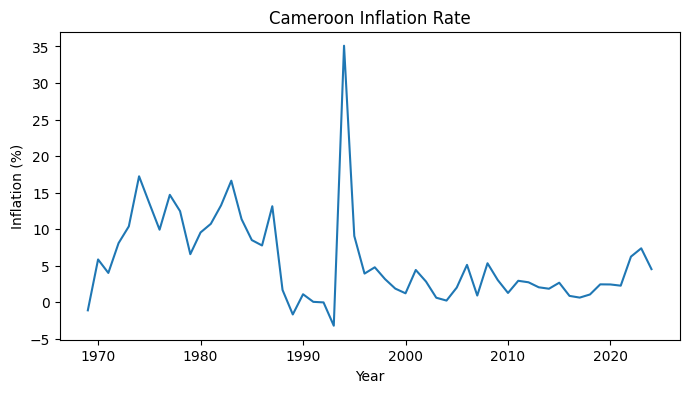

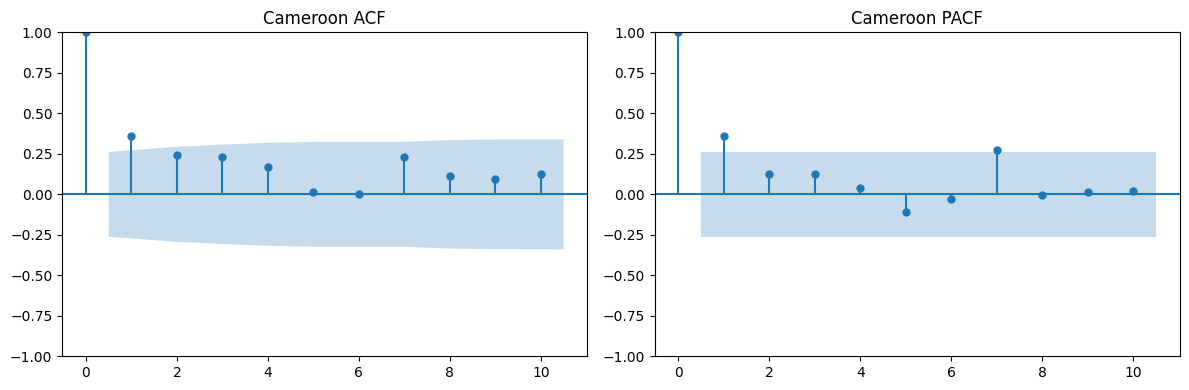

ADF Statistic: -5.0645, p-value: 0.000017
Series is stationary → d = 0
Best ARIMA order: (1, 0, 0), AIC: 362.2318
                               SARIMAX Results                                
Dep. Variable:              inflation   No. Observations:                   56
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -178.116
Date:                Wed, 28 Jan 2026   AIC                            362.232
Time:                        12:22:18   BIC                            368.308
Sample:                             0   HQIC                           364.587
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5613      2.064      2.694      0.007       1.516       9.607
ar.L1          0.

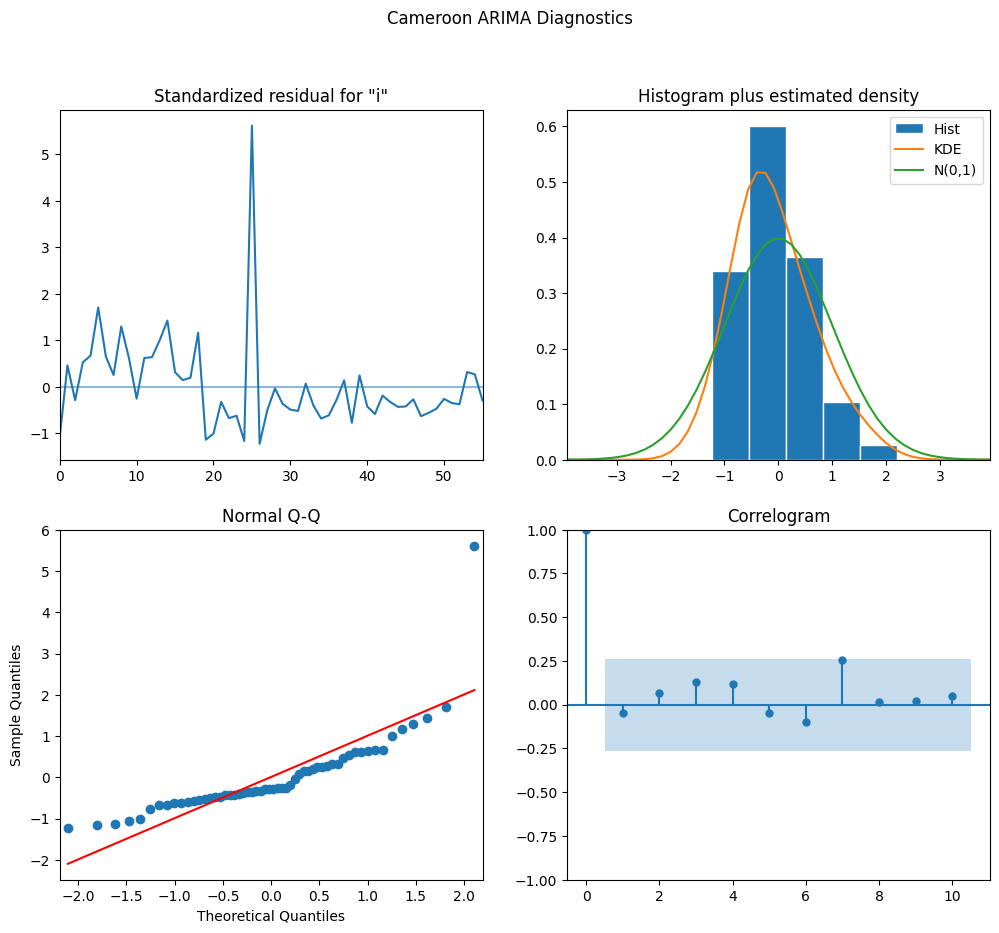

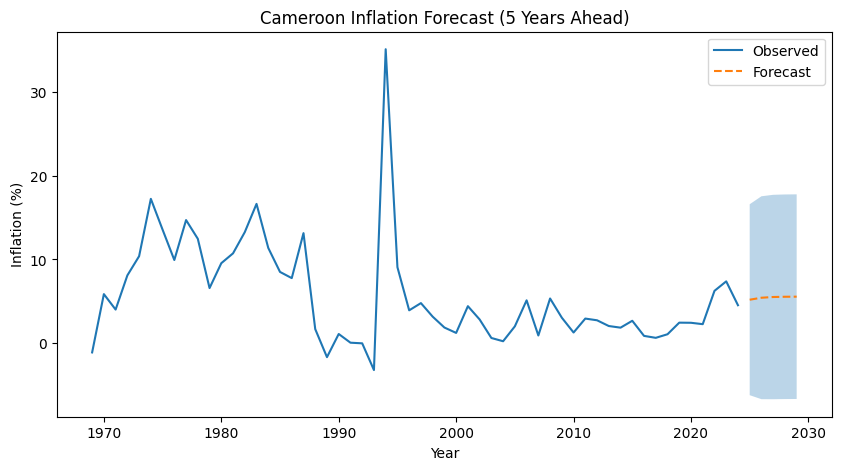


--- ANALYSIS FOR GHANA ---



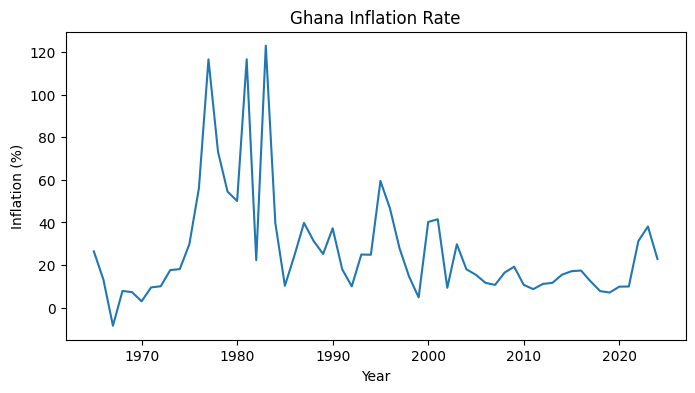

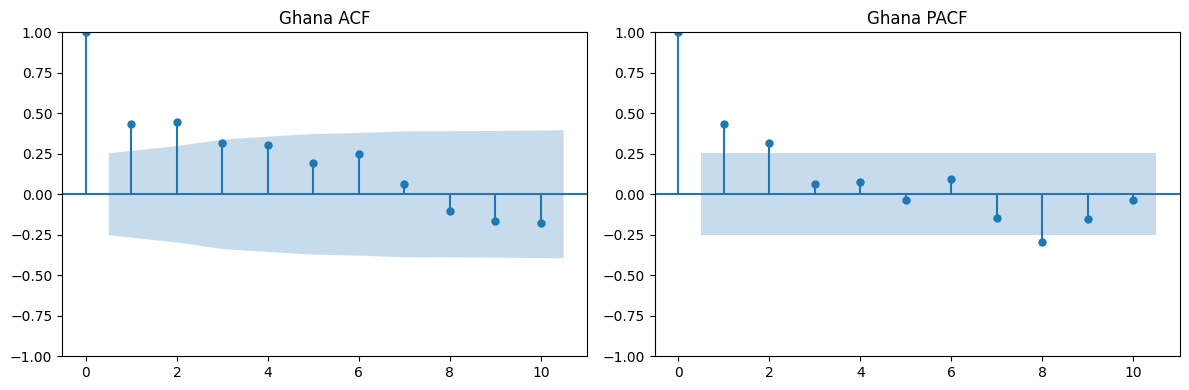

ADF Statistic: -2.8446, p-value: 0.052185
Series is non-stationary → d = 1
Best ARIMA order: (3, 1, 3), AIC: 542.6570
                               SARIMAX Results                                
Dep. Variable:              inflation   No. Observations:                   60
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -264.329
Date:                Wed, 28 Jan 2026   AIC                            542.657
Time:                        12:22:26   BIC                            557.200
Sample:                             0   HQIC                           548.334
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6383      0.288      2.213      0.027       0.073       1.204
ar.L2        

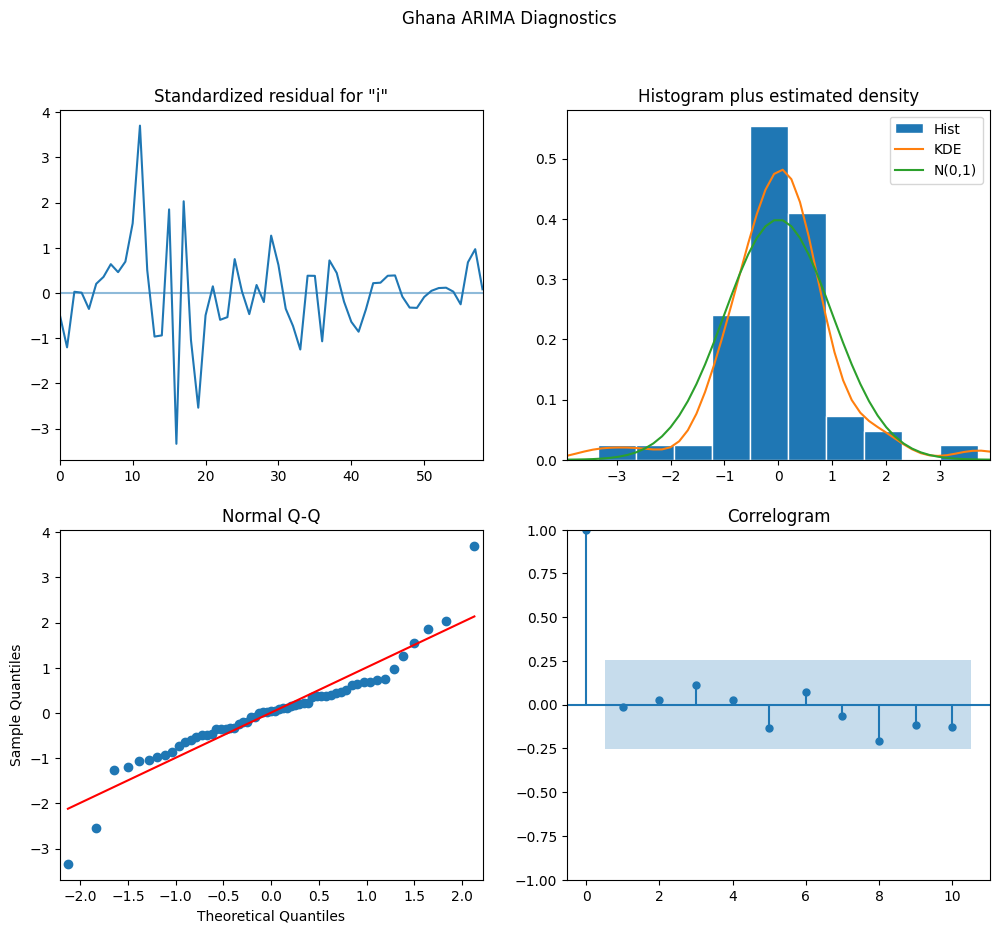

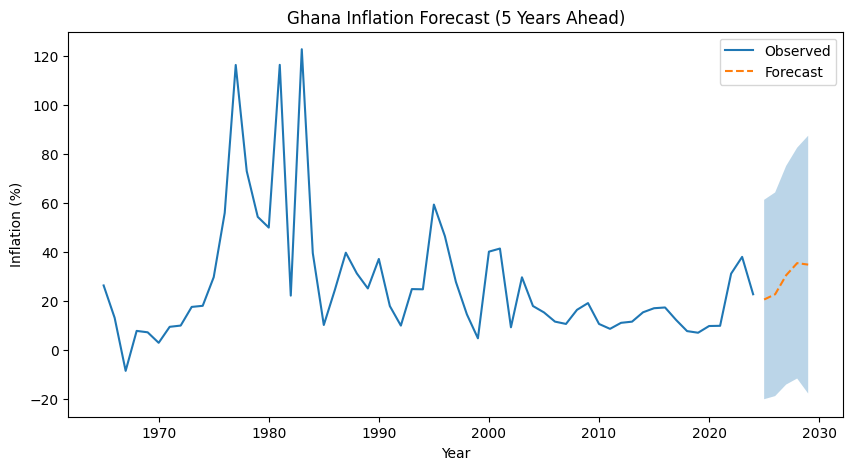


--- ANALYSIS FOR NIGERIA ---



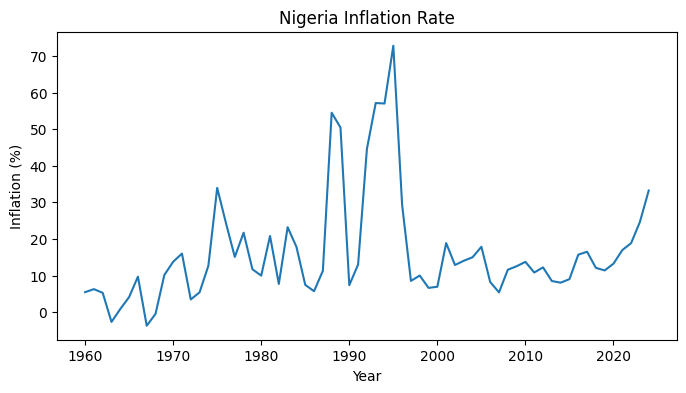

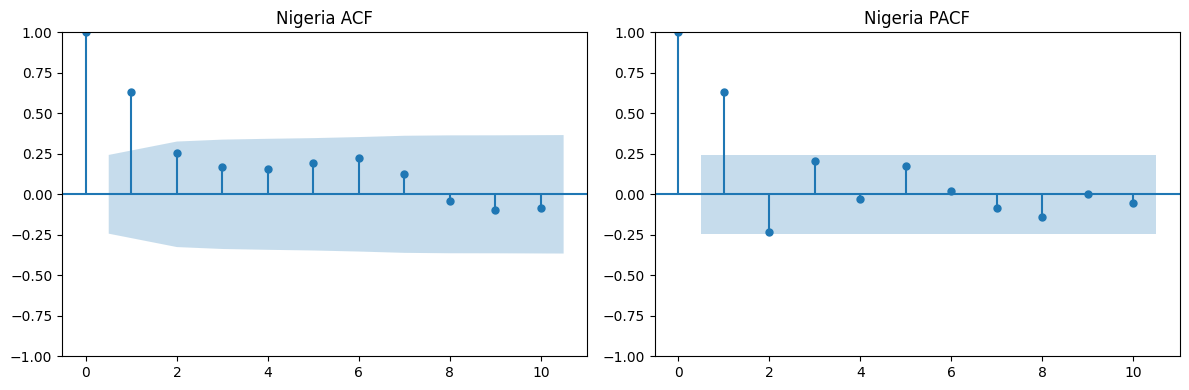

ADF Statistic: -2.8981, p-value: 0.045568
Series is stationary → d = 0
Best ARIMA order: (1, 0, 1), AIC: 502.6801
                               SARIMAX Results                                
Dep. Variable:              inflation   No. Observations:                   65
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -247.340
Date:                Wed, 28 Jan 2026   AIC                            502.680
Time:                        12:22:35   BIC                            511.378
Sample:                             0   HQIC                           506.112
                                 - 65                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.3882      4.391      3.732      0.000       7.781      24.995
ar.L1          0.

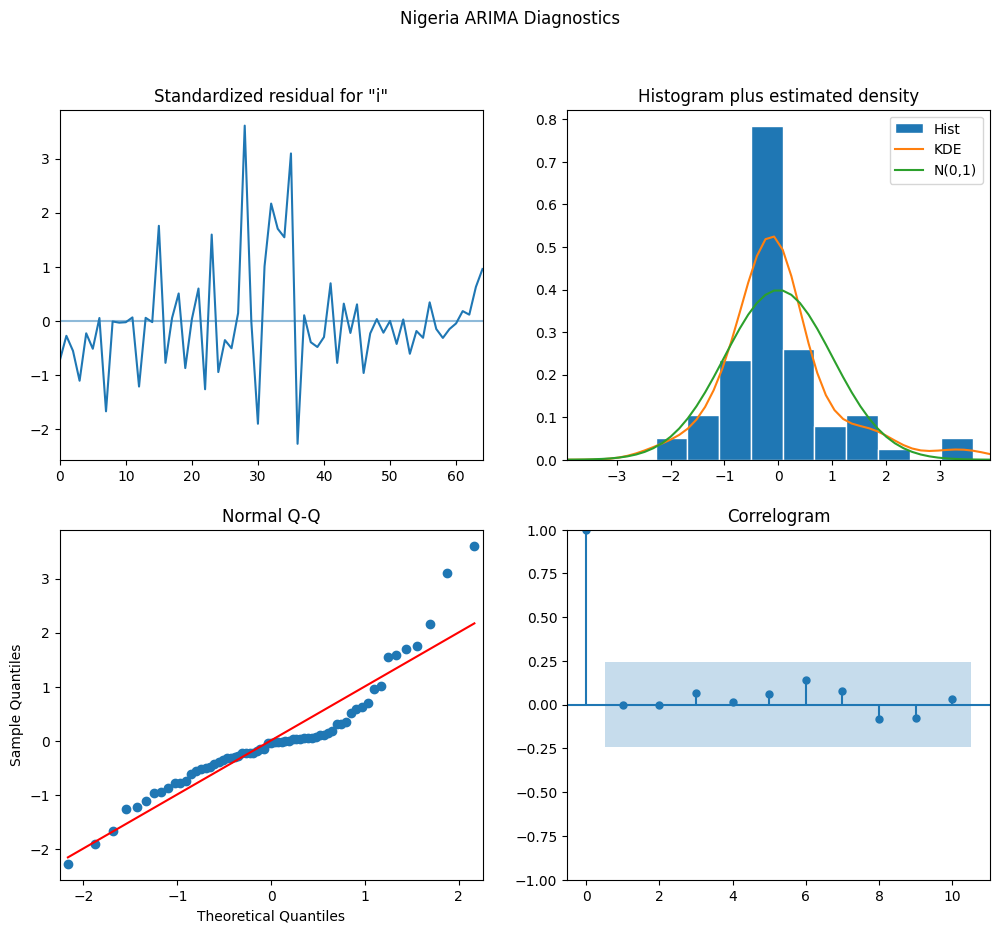

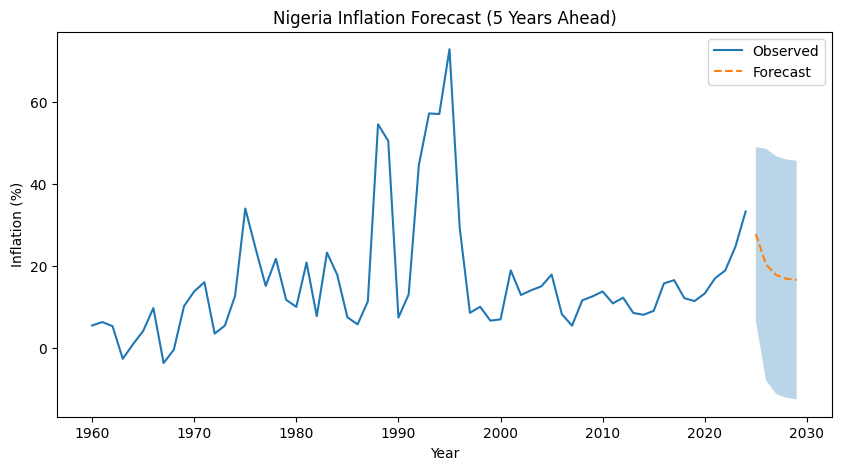


--- ANALYSIS FOR COTE D'IVOIRE ---



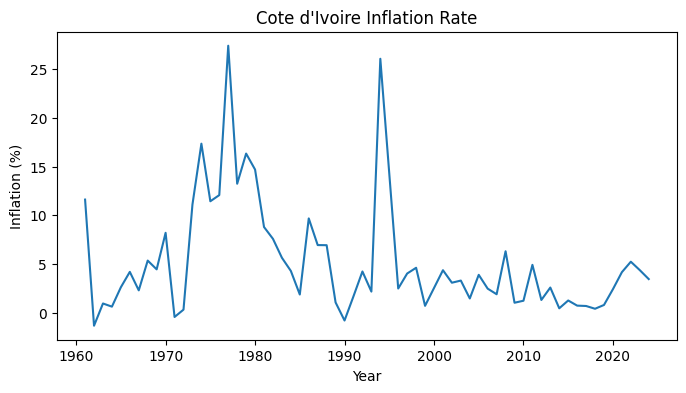

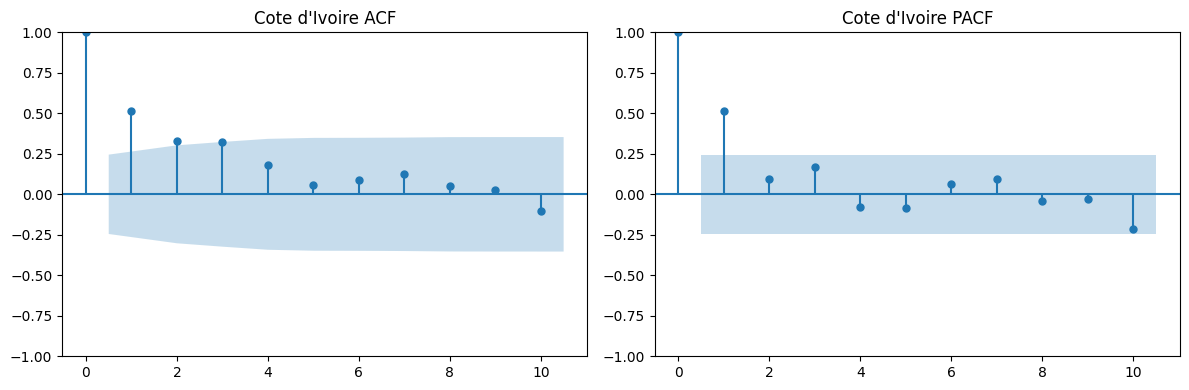

ADF Statistic: -4.4853, p-value: 0.000209
Series is stationary → d = 0
Best ARIMA order: (1, 0, 0), AIC: 393.4547
                               SARIMAX Results                                
Dep. Variable:              inflation   No. Observations:                   64
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -193.727
Date:                Wed, 28 Jan 2026   AIC                            393.455
Time:                        12:22:41   BIC                            399.931
Sample:                             0   HQIC                           396.006
                                 - 64                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3683      1.955      2.746      0.006       1.537       9.200
ar.L1          0.

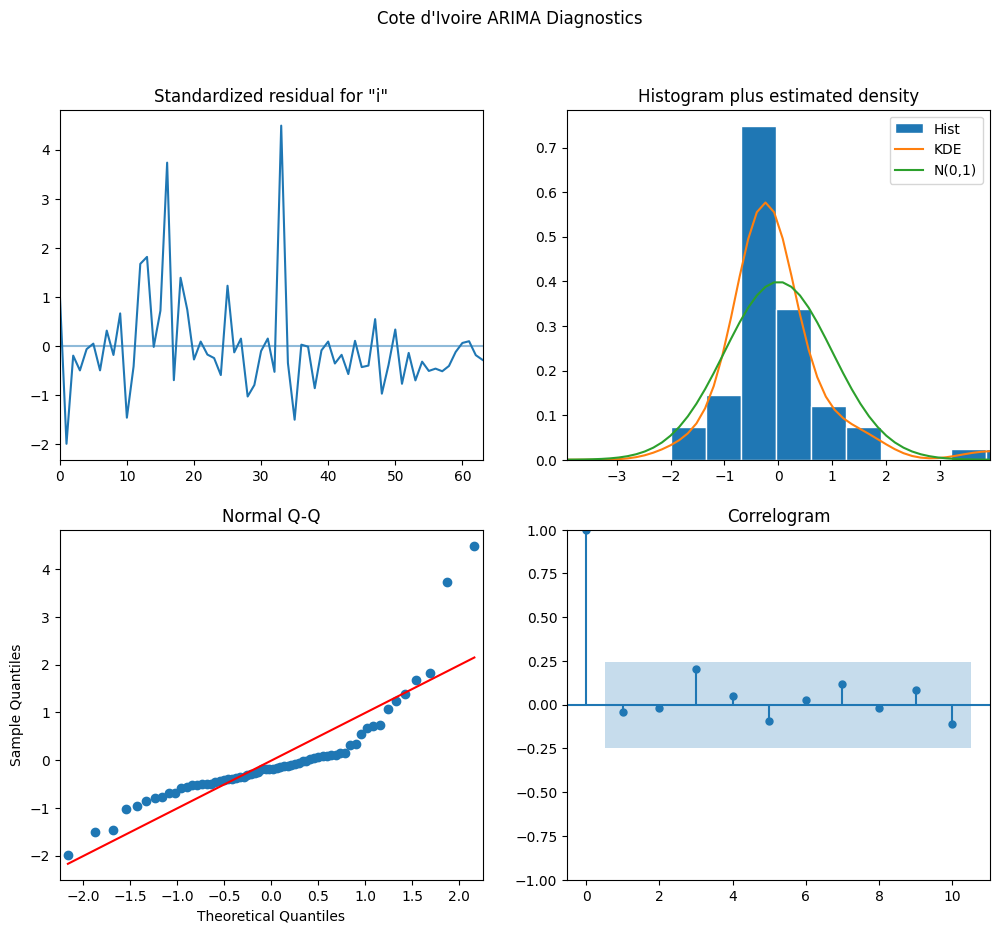

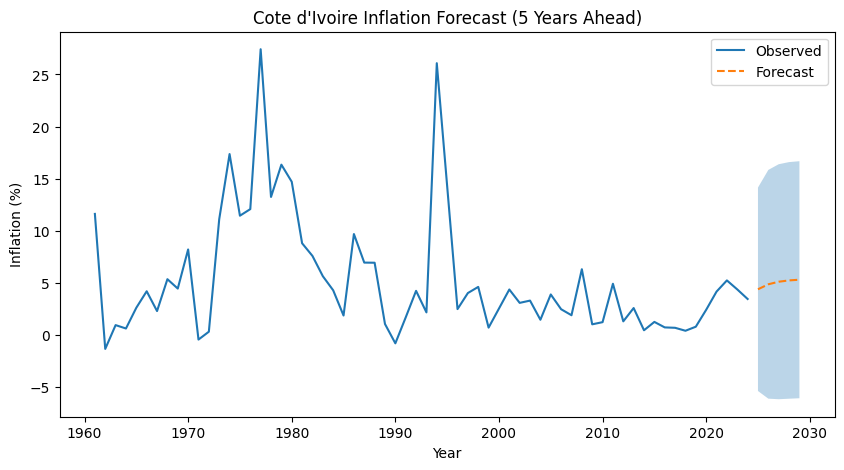

In [25]:

results = []
for c in countries:
    results.append(full_arima_analysis(df, c))


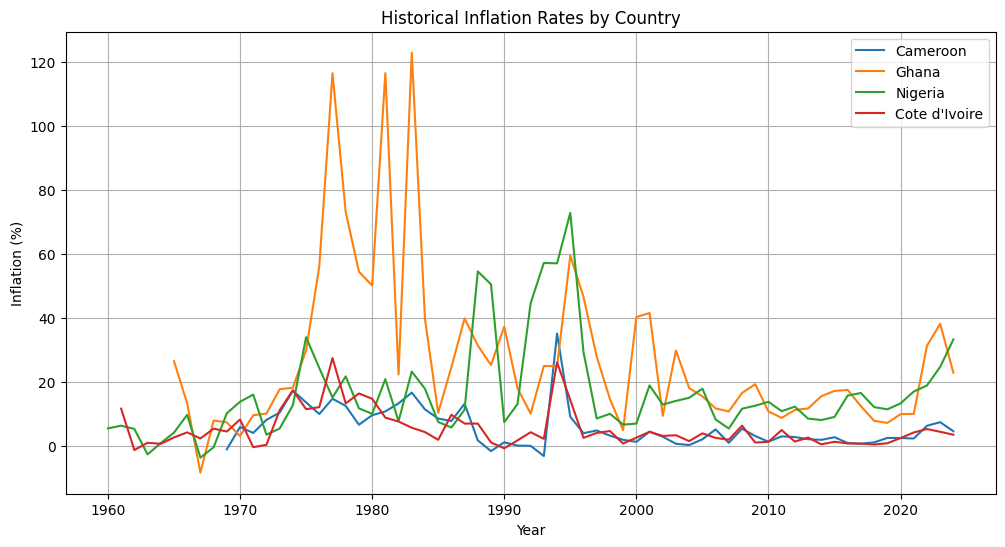

In [26]:
plt.figure(figsize=(12,6))

for res in results:
    plt.plot(res["Series"].index, res["Series"], label=res["Country"])

plt.xlabel("Year")
plt.ylabel("Inflation (%)")
plt.title("Historical Inflation Rates by Country")
plt.legend()
plt.grid(True)
plt.show()



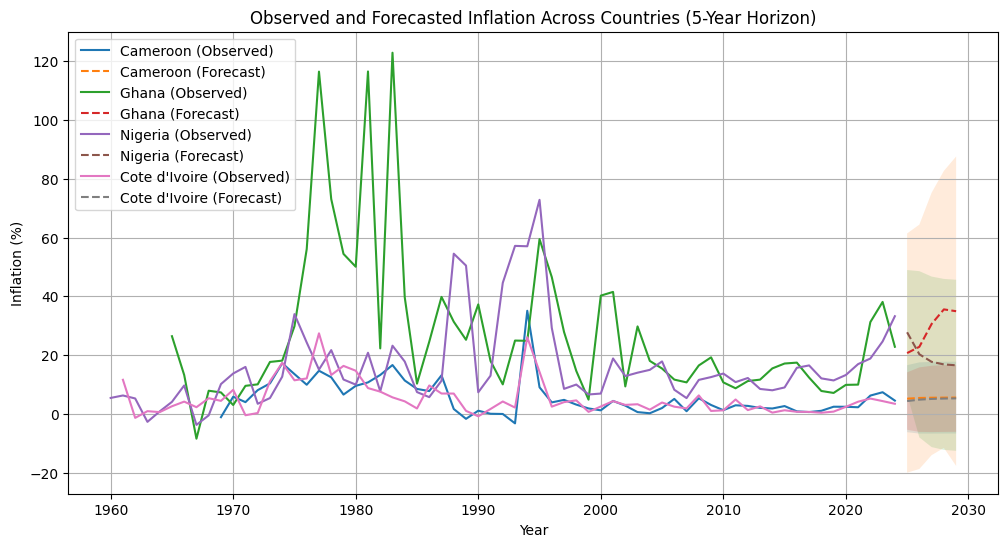

In [27]:
plt.figure(figsize=(12,6))

for res in results:
    # Historical
    plt.plot(
        res["Series"].index,
        res["Series"],
        label=f"{res['Country']} (Observed)"
    )
    
    # Forecast
    plt.plot(
        res["Forecast Mean"].index,
        res["Forecast Mean"],
        linestyle="--",
        label=f"{res['Country']} (Forecast)"
    )
    
    # Confidence interval
    plt.fill_between(
        res["Forecast CI"].index,
        res["Forecast CI"].iloc[:,0],
        res["Forecast CI"].iloc[:,1],
        alpha=0.15
    )

plt.xlabel("Year")
plt.ylabel("Inflation (%)")
plt.title("Observed and Forecasted Inflation Across Countries (5-Year Horizon)")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
comparison_table = pd.DataFrame({
    "Country": [r["Country"] for r in results],
    "ADF Statistic": [r["ADF Statistic"] for r in results], 
    "ADF p-value": [r["ADF p-value"] for r in results],
    "Best ARIMA Model": [r["Best ARIMA"] for r in results],
    "AIC": [r["AIC"] for r in results]
})

comparison_table


,Country,ADF Statistic,ADF p-value,Best ARIMA Model,AIC
0,Cameroon,-5.064517,0.000017,"(1, 0, 0)",362.231772
1,Ghana,-2.844558,0.052185,"(3, 1, 3)",542.657027
2,Nigeria,-2.898111,0.045568,"(1, 0, 1)",502.680103
3,Cote d'Ivoire,-4.485283,0.000209,"(1, 0, 0)",393.454728


In [29]:
comparison_data = []

for res in results:
    series = res["Series"]
    forecast_mean = res["Forecast Mean"]
    
    
    # Stationarity
    stationarity = "Stationary" if res["ADF p-value"] < 0.05 else "Non-stationary"
    
    # Forecast values (if available)
    forecast_values = {}
    if forecast_mean is not None:
        for i, val in enumerate(forecast_mean):
            forecast_values[f"Forecast Year {i+1}"] = round(val, 2)
    else:
        for i in range(5):
            forecast_values[f"Forecast Year {i+1}"] = np.nan
    
    # Combine all
    comparison_data.append({
        "Country": res["Country"],
        "ADF Statistic": round(res["ADF Statistic"],4),
        "ADF p-value": round(res["ADF p-value"],6),
        "Stationarity": stationarity,
        "Best ARIMA": str(res["Best ARIMA"]),
        "AIC": round(res["AIC"],2),
        **forecast_values
    })

comparison_table = pd.DataFrame(comparison_data)
comparison_table


,Country,ADF Statistic,ADF p-value,Stationarity,Best ARIMA,AIC,Forecast Year 1,Forecast Year 2,Forecast Year 3,Forecast Year 4,Forecast Year 5
0,Cameroon,-5.0645,0.000017,Stationary,"(1, 0, 0)",362.23,5.19,5.43,5.51,5.54,5.56
1,Ghana,-2.8446,0.052185,Non-stationary,"(3, 1, 3)",542.66,20.70,22.84,30.61,35.56,34.95
2,Nigeria,-2.8981,0.045568,Stationary,"(1, 0, 1)",502.68,27.78,20.29,17.72,16.85,16.54
3,Cote d'Ivoire,-4.4853,0.000209,Stationary,"(1, 0, 0)",393.45,4.38,4.86,5.11,5.23,5.30
